## Setup

Load required packages

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import random
import libpysal
import pysal
#import pysal.lib
import gpytorch
import torch
import math

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


Read data

In [2]:
data = pd.read_csv("C:/Users/kklemmer/Documents/GitHub/spacegan/analysis/grid_aug_ex1.csv")
#Create ID column
#data["id"] = np.asarray(list(range(0,len(data["longitude"])))).reshape(-1,1)

In [3]:
data.head(3)

,id,y,z,latitude,longitude,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10
0,1,-0.844504,1.370958,2.5,2.5,1,2,2,2,2,1,2,2,2,2
1,2,-0.832568,-0.564698,2.5,7.5,1,2,2,2,2,1,2,2,2,2
2,3,-0.793995,0.363128,2.5,12.5,1,0,2,2,2,1,2,2,2,2


## Spatial Grid Expansion

In [8]:
train_x = np.asarray(data[["longitude","latitude"]])
train_y = np.asarray(data[["y","z"]])

In [9]:
#from sklearn import preprocessing
#train_x = preprocessing.MinMaxScaler().fit_transform(train_x)
#train_y = preprocessing.MinMaxScaler().fit_transform(train_y)

In [10]:
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float()

In [11]:
#train_x = torch.tensor(data[["longitude","latitude"]].values).float()
#train_y = torch.tensor(data[["housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"]].values).float()

In [12]:
train_y.shape

torch.Size([400, 2])

In [13]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dim=2,has_lengthscale=True), grid_size=grid_size, num_dims=2,
            ), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [23]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 200
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/200 - Loss: 225.874
Iter 2/200 - Loss: 210.695
Iter 3/200 - Loss: 216.561
Iter 4/200 - Loss: 208.785
Iter 5/200 - Loss: 205.949
Iter 6/200 - Loss: 238.846
Iter 7/200 - Loss: 202.653
Iter 8/200 - Loss: 211.340
Iter 9/200 - Loss: 214.479
Iter 10/200 - Loss: 209.924
Iter 11/200 - Loss: 198.038
Iter 12/200 - Loss: 198.163
Iter 13/200 - Loss: 194.131
Iter 14/200 - Loss: 223.405
Iter 15/200 - Loss: 207.110
Iter 16/200 - Loss: 206.231
Iter 17/200 - Loss: 193.531
Iter 18/200 - Loss: 184.196
Iter 19/200 - Loss: 202.848
Iter 20/200 - Loss: 176.143
Iter 21/200 - Loss: 181.786
Iter 22/200 - Loss: 204.334
Iter 23/200 - Loss: 197.164
Iter 24/200 - Loss: 202.125
Iter 25/200 - Loss: 184.192
Iter 26/200 - Loss: 198.220
Iter 27/200 - Loss: 192.193
Iter 28/200 - Loss: 202.009
Iter 29/200 - Loss: 199.583
Iter 30/200 - Loss: 198.782
Iter 31/200 - Loss: 181.826
Iter 32/200 - Loss: 178.288
Iter 33/200 - Loss: 185.124
Iter 34/200 - Loss: 183.333
Iter 35/200 - Loss: 182.722
Iter 36/200 - Loss: 198.453
I

In [24]:
train_y[-1:,:]

tensor([[-0.8446,  0.9310]])

In [25]:
train_x[-1:,:]

tensor([[97.5000, 97.5000]])

In [26]:
#mll.likelihood(output).log_prob(train_y).size()

In [27]:
# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood()

In [28]:
# Make predictions
with torch.no_grad(), gpytorch.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(train_x))
    # Get mean
    mean = observed_pred.mean
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()

In [29]:
mean

tensor([[-8.4184e-01, -1.8639e-03],
        [-8.2980e-01, -2.1314e-03],
        [-7.9361e-01, -2.4382e-03],
        [-7.2866e-01, -2.4771e-03],
        [-6.3814e-01, -3.5515e-03],
        [-5.2499e-01, -5.0166e-03],
        [-3.8979e-01, -6.4341e-03],
        [-2.2206e-01, -8.2411e-03],
        [-3.0215e-02, -1.0260e-02],
        [ 1.8571e-01, -1.2390e-02],
        [ 4.2853e-01, -1.4499e-02],
        [ 6.9096e-01, -1.7392e-02],
        [ 9.8345e-01, -2.0861e-02],
        [ 1.3078e+00, -2.4633e-02],
        [ 1.6420e+00, -2.7925e-02],
        [ 2.0107e+00, -3.1799e-02],
        [ 2.4104e+00, -3.6354e-02],
        [ 2.8311e+00, -4.1482e-02],
        [ 3.2724e+00, -4.5653e-02],
        [ 3.7433e+00, -4.9979e-02],
        [-8.2809e-01, -2.1638e-03],
        [-8.4089e-01, -2.1228e-03],
        [-8.3228e-01, -1.9975e-03],
        [-7.9237e-01, -1.9126e-03],
        [-7.3043e-01, -2.6559e-03],
        [-6.4341e-01, -3.8388e-03],
        [-5.2907e-01, -5.1531e-03],
        [-3.8891e-01, -6.557

In [30]:
mean[:1,:]

tensor([[-0.8418, -0.0019]])

In [31]:
train_y[:1,:]

tensor([[-0.8445,  1.3710]])

In [34]:
pred = mean.numpy()

In [38]:
data["y_pred"] = pred[:,0]
data["z_pred"] = pred[:,1]

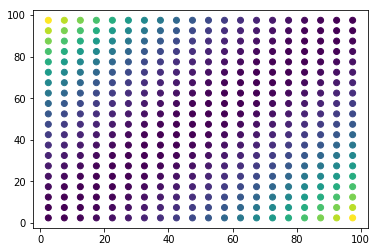

In [44]:
import matplotlib.pyplot as plt
plt.scatter(data["longitude"],data["latitude"],c=data["y"])